Bayesian System Identification of a Harmonic Oscillator using Probabilistic Programming
===========================

In this problem you will use probabilistic programming to infer the mass, spring constant, damping, and initial velocity of a Mass-Spring-Damper system, given only noisy measurements of that system.

For this, you can use any probabilistic programming library that you like (e.g., PyMC3, Tensorflow Probability, Pyro, Edward, Turing, etc.). If you want to leverage some of the examples from class then we happened to use PyMC3, however this problem is still solvable using any other library.

In [ ]:
# If using PyMC3 you may want to make sure PyMC3 and arviz is installed
# Uncomment below, if so, otherwise 
#!pip install arviz
# or, if you need pymc3 as well:
#!pip install pymc3[plots]
# Alternatively, you can run this in a colab instance, like shown in class

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')

# Model Definition: Damped Harmonic Oscillator
From Dynamics class, we can recall that the solution to an unforced damped harmonic oscillator (like a Mass-Spring-Damper System with no external forces on it) is:
$$
\hat{y}(t) = A\exp(\frac{-c t}{2m})\sin(\omega t+\phi)
$$
where
$$
\begin{eqnarray}
  \omega &=& \frac{\sqrt{4mk-c^2}}{2m}\\
  B &=& \frac{v_0+y_0 \cdot \frac{c}{2m}}{\omega} \\
  \phi &=& \tan^{-1}\left(\frac{y_0}{B}\right)\\
  A &=& \sqrt{y_0^2 +  B^2}
\end{eqnarray}
$$
and $m$, $c$, $k$, $y_0$, and $v_0$ are the mass, damping coefficient, spring constant, initial position, and initial velocity, respectively.

However, in this problem we will assume that we are only given position measurement data, which is slightly noisy, and that we want to infer (using probabilistic programming) the possible values for the mass, spring constant, damping coefficient, and initial velocity, given that we know the system started from $y_0=1$.

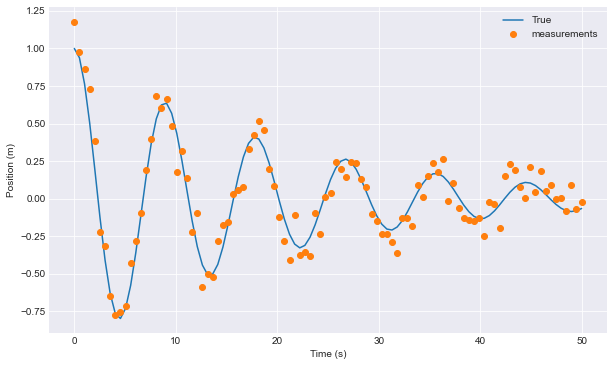

In [2]:
# Code to generate the noisy measurements
# Number of Timesteps
T = 100
np.random.seed(0)

# Textbook solution to Unforced Mass-Spring-Damper Harmonic Oscillator
def MSD(t,m,k,c,y0,v0):
  omega = np.sqrt(4*m*k-c**2)/(2*m)
  B = (v0+y0*c/(2*m))/omega 
  phi = np.arctan(y0/B)
  A = np.sqrt(y0**2 +  B**2)
  y = A*np.exp(-c*t/(2*m))*np.sin(omega*t+phi)
  return y

# Simulate the true system:
time_vec = np.linspace(0, 50, T)
ytrue = MSD(time_vec, 
            m=10, 
            k=5,
            c=1,
            y0=1,
            v0=0)

# Add Measurement Noise
measurements = ytrue + 0.1*np.random.randn(T)

plt.figure(figsize=(10, 6))
plt.plot(time_vec, ytrue, label='True')
plt.plot(time_vec, measurements,'o', label='measurements')
plt.legend(loc='best')
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.show()


# Task1: Build the Probabilistic Model

Using the probabilistic programming language of your choice, build a probabilistic model of the position as a function of time, with the following prior beliefs about the other system parameters:
$$
P(\mathbf{y},m,k,c,v_0|T) = \sum_{t \in T} {\cal N}(y_t | \hat{y}(t,m,k,c,v_0),\sigma^2)P(m)P(c)P(k)P(v_0)P(sigma)
$$
where
$$
\begin{eqnarray}
  P(m)&\sim & {\cal N}(\mu_m=10, \sigma_m = 0.01) \\
  P(k)&\sim & {\cal N}(\mu_k=10, \sigma_k = 5)  \\
  P(c)&\sim & {\cal N}(\mu_c=5, \sigma_c = 2)  \\
  P(v_0)&\sim & {\cal N}(\mu_{v_0}=0, \sigma_{v_0} = 5)  \\
  P(sigma )&\sim & \mathrm{Gamma}(\alpha = 0.2, \beta = 1) \\
\end{eqnarray}
$$

While this seems like perhaps a complicated model, using probabilistic programming this basically means:

1. Instantiate probabilistic variables `m`,`c`,`k`, `v0` and `sigma` with the appropriate Normal and Gamma prior distributions.
2. Use them when computing the dynamics solution above.
3. Set the output variable `y` to be the observed variable using `measurements` as the observations.
4. Sample the model with N=15K samples. (e.g., I would suggest the NUTS sampler with 15K samples and using around 2000 tuning samples). Use at least two chains for comparison sake later.

Hint: If you have issues getting your sampling chains to converge, you can try: (1) increasing the number of samples, (2) increasing the number of tuning samples you allow `tuning = ####`, or (3) increasing the target acceptance rate for the MCMC samples (`target_accept=0.95` or `.99`, etc.). You can also increase the number of independent chains via `chains=3` or `4` or other numbers, though I would try increasing the number of samples first.

Hint 2: You will notice that our prior belief about the mass is really tight ($\sigma_m=0.01$). This is on purpose and not a typo. Task 3 will explore what happens if this is not the case. In more realistic problems, we may not know the mass with such accuracy, though for this task we will assume that we do.

Hint 3: Particularly eagle-eyed students may question the use of, e.g., the Normal distribution on parameters like Mass or damping coefficient, etc., since, technically, that could mean there is a probability of getting a negative mass or stiffness or damping etc. which is not physically sound and so forth. This is true, and it would be in fact far more reasonable to pick a distribution on the positive reals, such as the Log-Normal, Half-Cauchy, Truncated Normal, Exponential, or others. Feel free to do so if you like, but for simplicity sake I am asking everyone to do Normals for now.


In [3]:
# Your Model Code Here
import pymc3 as pm

In [4]:
basic_model = pm.Model()

with basic_model:
    # Priors for unknown model parameters
    m = pm.Normal('m', mu = 10, sd = 0.01)
    k = pm.Normal('k', mu = 10, sd = 5)
    c = pm.Normal('c', mu = 5, sd = 2)
    v0 = pm.Normal('v0', mu =0, sd=5)
    sigma = pm.Gamma('sigma', alpha = 0.2, beta = 1)
    
    # Expected value of outcome
    muy = MSD(time_vec, 
            m=m, 
            k=k,
            c=c,
            y0=1,
            v0=v0)
    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=muy, sd=sigma, observed=measurements)

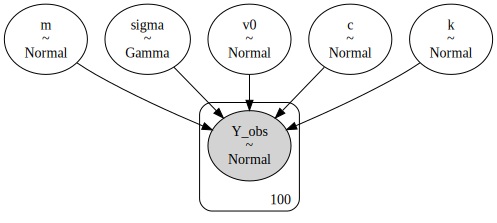

In [5]:
pm.model_to_graphviz(basic_model)

In [6]:
import warnings
#warnings.filterwarnings(action='once')
warnings.filterwarnings("ignore", category=DeprecationWarning)
#warnings.filterwarnings("ignore", category=Warning)

In [7]:
# Your Sampling Code Here

In [9]:
%%time
# Sampling
with basic_model:
    # draw posterior samples
    mc_trace = pm.sample(30000, tune=3000, target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, v0, c, k, m]


Sampling 2 chains for 3_000 tune and 30_000 draw iterations (6_000 + 60_000 draws total) took 85 seconds.


CPU times: user 25.3 s, sys: 1.79 s, total: 27.1 s
Wall time: 1min 32s


# Task 2: Inspect the model

Now that you have your samples, go ahead and inspect the output of the probabilistic program. Specifically:

## Plot the trace plots of the uncertain parameters.




/Users/sarahhonarvar/opt/anaconda3/envs/ENME743/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<AxesSubplot:title={'center':'m'}>,
        <AxesSubplot:title={'center':'m'}>],
       [<AxesSubplot:title={'center':'k'}>,
        <AxesSubplot:title={'center':'k'}>],
       [<AxesSubplot:title={'center':'c'}>,
        <AxesSubplot:title={'center':'c'}>],
       [<AxesSubplot:title={'center':'v0'}>,
        <AxesSubplot:title={'center':'v0'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

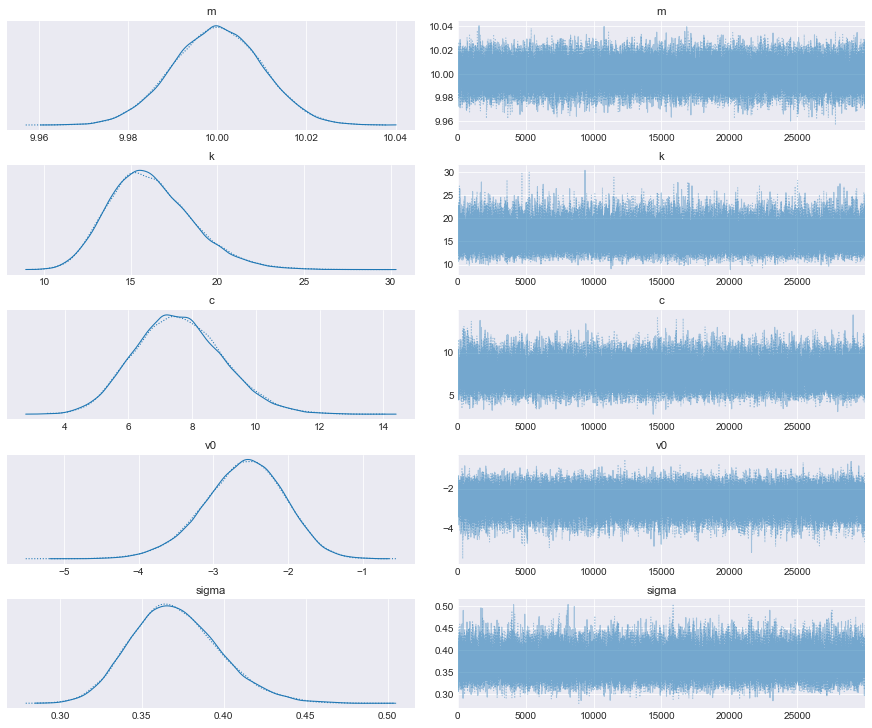

In [10]:
# Your Code here
pm.traceplot(mc_trace)

Q: Do the different chains produce similar estimates of the parameters? Has the model seemed to converge? What evidence are you using to assess either answer?

A: In this case, from the above figure, we can see that the two chains produce almost similar results with a little deviation. The number of divergence in the warning above is zero 



## Provide the Summary statistics of the uncertain parameters
That is, compute the mean, and 95% posterior interval for the main system parameters (mass, spring constant, damping).

In [11]:
# Your code here
pm.summary(mc_trace)

/Users/sarahhonarvar/opt/anaconda3/envs/ENME743/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
m,10.000,0.010,9.981,10.018,0.000,0.000,60229.0,60229.0,60222.0,42472.0,1.0
k,16.166,2.426,11.909,20.822,0.012,0.009,39829.0,37525.0,42678.0,36284.0,1.0
c,7.595,1.382,5.081,10.221,0.007,0.005,37770.0,36947.0,38116.0,40611.0,1.0
v0,-2.591,0.539,-3.608,-1.589,0.003,0.002,41326.0,39939.0,41902.0,40239.0,1.0
sigma,0.371,0.027,0.322,0.423,0.000,0.000,56894.0,55824.0,57984.0,41947.0,1.0


Q: Given that you know the true system parameters that generate the data (seen in the code at the top that generated the measurements), do these estimates seem reasonable? Do their 95% credible intervals include the correct parameters? Are any unreasonable? Explain why.

A: Your Answer Here

/Users/sarahhonarvar/opt/anaconda3/envs/ENME743/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

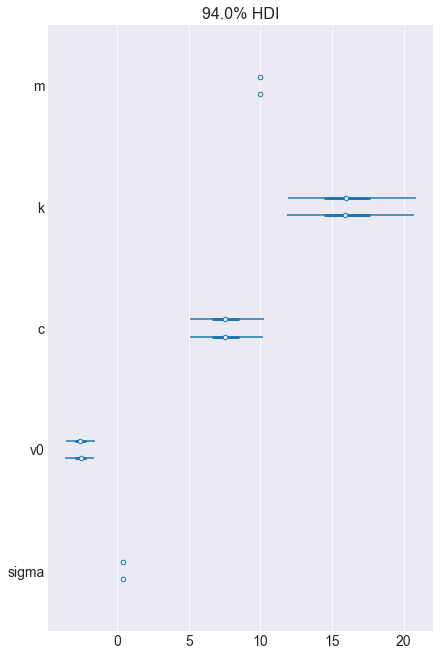

In [12]:
pm.plots.forestplot(mc_trace)

## Plot the 95% CI bound on the predicted true function
Using the samples you gathered while running your probabilistic program, produce a plot that compares (with time on the x-axis):

1. The provided measurements (`measurements`)
2. The true function (`ytrue`)
3. The mean predicted function (from your model)
4. The 95% CI upper bound on the function over time (from your model)
5. The 95% CI lower bound on the function over time (from your model).

Ideally, your 95% CI should contain the true function, if your probabilistic program is well-calibrated (i.e., has an appropriate measure of its own uncertainty).

In [ ]:
# Your Code Here
pm.plot_posterior(mc_trace)

## Plot the posterior covariance between the system parameters

Specifically, plot the pairwise joint probability density between the posterior distributions of the variables for mass, spring constant, and damping. You can do this by plotting for each point on the trace, the pairwise relationship between m vs k, k vs c, and m vs c.

Hint: Using a function like pairplot will be useful here, since such functions draw joint probability points automatically.

In [ ]:
# Your Code Here
pm.pairplot(mc_trace, var_names=['m', 'k', 'c'], divergences=True);

Q: What do you notice, if anything about the covariance between m, c, and k?

A: Your Answer Here

# (743 Only) Task 3: Uncertain mass

Above, we assumed that we had a fairly good prior idea of the mass of the system. What if we were less sure and wanted to try to infer the mass as well?

To see how this would turn out, re-run your original model from above, except this time make the prior belief about the mass less certain -- perhaps you are not sure exactly how much the mass might weigh.... That is, instead of making your prior distribution on the mass $P(m) \sim  {\cal N}(\mu_m=10, \sigma_m = 0.01)$, *instead* increase the standard deviation to $\sigma_m = 3$ -- a significant increase in prior uncertainty (e.g., the mass could now range anywhere from around 1-ish to 20-ish.

Re-Run your probabilistic program from above, and include some of the same outputs such as (1) the trace plot, (2) the summary statistics of the parameters, and (3) the posterior covariance between m, c, and k. Note any changes. Likewise, re-plot the predicted displacement vs t as you did above (including the upper and lower bounds). Note any changes.

Warning: Convergence on these sampling steps may be signficantly slower than what you saw for Task 2, so budget waiting time accordingly.


In [13]:
# Your Model code here
basic_model = pm.Model()

with basic_model:
    # Priors for unknown model parameters
    m = pm.Normal('m', mu = 10, sd = 3)
    k = pm.Normal('k', mu = 10, sd = 5)
    c = pm.Normal('c', mu = 5, sd = 2)
    v0 = pm.Normal('v0', mu =0, sd=5)
    sigma = pm.Gamma('sigma', alpha = 0.2, beta = 1)
    
    # Expected value of outcome
    muy = MSD(time_vec, 
            m=m, 
            k=k,
            c=c,
            y0=1,
            v0=v0)
    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=muy, sd=sigma, observed=measurements)

In [14]:
# Your Sampling Code here

In [24]:
%%time
# Sampling
with basic_model:
    # draw posterior samples
    mc_trace = pm.sample(100000, tune=100000, target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, v0, c, k, m]


Sampling 2 chains for 100_000 tune and 100_000 draw iterations (200_000 + 200_000 draws total) took 6074 seconds.
There were 4580 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4654 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


CPU times: user 3min 12s, sys: 20.7 s, total: 3min 32s
Wall time: 1h 41min 35s


In [ ]:
# Your Visualization/Inspect code here
pm.traceplot(mc_trace)

In [ ]:
pm.summary(mc_trace)

In [ ]:
pm.plot_posterior(mc_trace)

In [ ]:
pm.pairplot(mc_trace, var_names=['m', 'k', 'c'], divergences=True);

Q: Do you get the same results trace plot or summary statistics as before? If not, what has changed?

A: Your Answer Here

Q: How did the posterior covariance between m, k, and c change? What do you think is causing this change and why would this cause possible problems for estimating the mass, spring constant, and damping?

Hint: To help understand the above, see the below code where we plot the behavior of four different (deterministic) systems:

1. m = 10, k = 5, c = 1
2. m = 20, k = 10, c = 2
3. m = 30, k = 15, c = 3
4. m = 30, k = 20, c = 3

What is going on here? Look at the formulas above for $y$, $B$, and $\omega$. What happens when we change things in a fashion similar to cases 1-3? How might this affect the likelihood $P(\mathbf{y},m,k,c,v_0|T)$? What might this mean for our estimates of the uncertain parameters m, c, and k? This may help you think through your answer to the above question.


In [ ]:
# Plot a few example systems with different masses, spring constants, and damping
y1 = MSD(time_vec, 
           m=10, k=5, c=1, y0=1, v0=0)
y2 = MSD(time_vec, 
           m=20, k=10, c=2, y0=1, v0=0)
y3 = MSD(time_vec, 
           m=30, k=15, c=3, y0=1, v0=0)

y4 = MSD(time_vec, 
           m=30, k=20, c=3, y0=1, v0=0)


plt.figure(figsize=(4, 3))
plt.plot(time_vec, y1, label='y1')
plt.plot(time_vec, y2, label='y2')
plt.plot(time_vec, y3, label='y3')
plt.plot(time_vec, y4, label='y4')
plt.legend(loc='best')
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.show()